# Parameter Optimization (Step 2 Replication)

## ⚠️ CRITICAL: Fixing the Overfitting Bug

**Original Problem (Step2):**
- Tested different momentum periods on entire dataset
- Selected best parameters based on full dataset performance
- **NO train/test split** → **SEVERE OVERFITTING**
- Results were unrealistically optimistic

**Our Solution:**
- ✅ **Train/Validation/Test splits (60/20/20)**
- ✅ **Optimize on train set only**
- ✅ **Select best on validation set**
- ✅ **Report final results on test set (unseen data)**
- ✅ **Walk-forward analysis** for time-series validation

This demonstrates proper methodology for parameter selection!

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO)

import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("✓ Imports complete")

✓ Imports complete


## 1. Load Data (Same as Previous Notebooks)

In [2]:
from CoinTrading.data import DataLoader
from CoinTrading.indicators import Momentum, RSI, Noise, EMA

loader = DataLoader()
tickers = loader.client.get_tickers(quote_asset='USDT')
data = loader.load_multiple(tickers, skip_errors=True)

# Prepare data with indicators
indicators = [
    Momentum(period=7), Momentum(period=14), Momentum(period=20), 
    Momentum(period=21), Momentum(period=60),
    RSI(period=14), Noise(period=15),
    EMA(period=7), EMA(period=20), EMA(period=50)
]

processed_data = {}
for symbol, df in data.items():
    if len(df) < 200: continue
    result = df.copy()
    for ind in indicators:
        result = ind.calculate(result)
    processed_data[symbol] = result.dropna()

print(f"Prepared {len(processed_data)} symbols")

INFO:CoinTrading.data.binance_client:Initialized BinanceClient for futures market
INFO:CoinTrading.data.data_loader:DataLoader initialized with cache: .cache/ohlcv
INFO:CoinTrading.data.binance_client:Found 562 USDT pairs
INFO:CoinTrading.data.data_loader:Loaded 10/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 20/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 30/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 40/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 50/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 60/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 70/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 80/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 90/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 100/562 symbols
INFO:CoinTrading.data.data_loader:Loaded 110/562 symbols
INFO:CoinTrading.data.data_loader:Downloading BTCSTUSDT from Binance API
ERROR:CoinTrading.data.binance_client:Failed to fetch OHLCV for BTCSTUSDT: APIError(cod

Prepared 403 symbols


## 2. Grid Search with Train/Val/Test Splits

**Proper parameter optimization with long-only strategy (matching original Step2)**

In [3]:
from CoinTrading.strategy import MomentumLongOnlyStrategy
from CoinTrading.optimization import GridSearch

# Add TP column if not already present (needed for universe selection)
for symbol in processed_data:
    df = processed_data[symbol]
    if all(col in df.columns for col in ['high', 'low', 'close']):
        if 'TP' not in df.columns:
            df['TP'] = (df['high'] + df['low'] + df['close']) / 3.0

print(f"✓ TP column ready for {len(processed_data)} symbols")

# Define parameter grid - testing different momentum periods (matching original Step2)
param_grid = {
    'indicator': ['mom7', 'mom14', 'mom20', 'mom21', 'mom60'],
    'long_top_n': [5],
    'long_bottom': [False]  # Long top 5 only (not bottom 5)
}

# Run grid search with proper train/val/test splits
grid_search = GridSearch(
    data=processed_data,
    strategy_class=MomentumLongOnlyStrategy,
    param_grid=param_grid,
    train_ratio=0.6,   # 60% for training
    val_ratio=0.2,     # 20% for validation (parameter selection)
    test_ratio=0.2,    # 20% for test (final evaluation)
    optimization_metric='sharpe',
    transaction_fee=0.003
)

results_df = grid_search.run()

print("\n" + "="*80)
print("Grid Search Results (Long Top 5 Only)")
print("="*80)
print(results_df[['param_indicator', 'train_sharpe', 'val_sharpe', 'test_sharpe']].to_string())

INFO:CoinTrading.optimization.grid_search:Initialized GridSearch: 5 combinations, optimize on sharpe
INFO:CoinTrading.optimization.grid_search:Train: 2023-06-30 to 2024-11-07
INFO:CoinTrading.optimization.grid_search:Val:   2024-11-08 to 2025-04-22
INFO:CoinTrading.optimization.grid_search:Test:  2025-04-23 to 2025-10-05
INFO:CoinTrading.optimization.grid_search:Starting grid search: 5 combinations
INFO:CoinTrading.optimization.grid_search:[1/5] Testing: {'indicator': 'mom7', 'long_top_n': 5, 'long_bottom': False}
INFO:CoinTrading.strategy.momentum_simple:Initialized MomentumLongOnlyTop(mom7): long_top=5, indicator=mom7, universe=21
INFO:CoinTrading.backtesting.engine:Initialized backtesting engine with 389 symbols, 497 trading days
INFO:CoinTrading.backtesting.engine:Running backtest from 2023-06-30 to 2024-11-07


✓ TP column ready for 403 symbols


INFO:CoinTrading.backtesting.engine:Backtest complete. Final equity: 0.9471 (-5.29%)
INFO:CoinTrading.backtesting.engine:Initialized backtesting engine with 389 symbols, 663 trading days
INFO:CoinTrading.backtesting.engine:Running backtest from 2024-11-08 to 2025-04-22
INFO:CoinTrading.backtesting.engine:Backtest complete. Final equity: 0.5780 (-42.20%)
INFO:CoinTrading.backtesting.engine:Initialized backtesting engine with 389 symbols, 829 trading days
INFO:CoinTrading.backtesting.engine:Running backtest from 2025-04-23 to 2025-10-05
INFO:CoinTrading.backtesting.engine:Backtest complete. Final equity: 0.7756 (-22.44%)
INFO:CoinTrading.optimization.grid_search:  → New best! Val sharpe: -0.47
INFO:CoinTrading.optimization.grid_search:  Train: CAGR=-3.7% MDD=-76.8% Sharpe=0.38
INFO:CoinTrading.optimization.grid_search:  Val:   CAGR=-70.1% MDD=-70.3% Sharpe=-0.47
INFO:CoinTrading.optimization.grid_search:  Test:  CAGR=-42.6% MDD=-79.1% Sharpe=0.49
INFO:CoinTrading.optimization.grid_search


Grid Search Results (Long Top 5 Only)
  param_indicator  train_sharpe  val_sharpe  test_sharpe
3           mom21      0.553606    0.932992     0.468910
1           mom14      0.581273    0.820802     0.459214
4           mom60      0.909025    0.697704    -0.025191
2           mom20      0.733968    0.651935     0.401183
0            mom7      0.381521   -0.471129     0.492666


INFO:CoinTrading.strategy.momentum_simple:Initialized MomentumLongOnlyTop(mom7): long_top=5, indicator=mom7, universe=21
INFO:CoinTrading.backtesting.engine:Initialized backtesting engine with 403 symbols, 829 trading days
INFO:CoinTrading.backtesting.engine:Running backtest from 2023-06-30 to 2025-10-05


✓ Added TP column to 403 symbols

Testing MomentumLongOnlyStrategy (Long top 5 only)...


INFO:CoinTrading.backtesting.engine:Backtest complete. Final equity: 0.4853 (-51.47%)


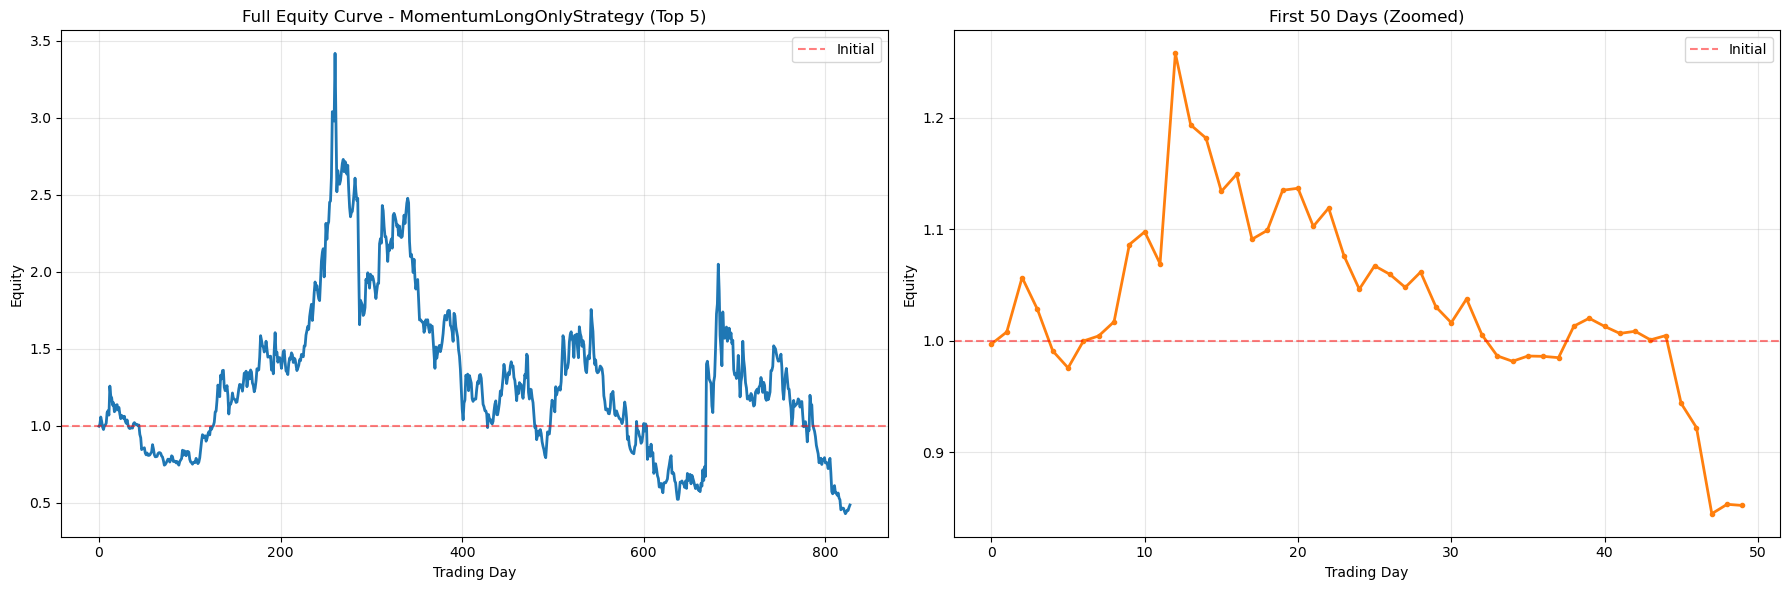


Equity Statistics:
  Initial equity: 1.000000
  Final equity: 0.485309
  Min equity: 0.428747 (day 2025-09-30 00:00:00)
  Max equity: 3.418475 (day 2024-03-17 00:00:00)
  Total return: -51.5%

First 10 trading days:
  Day 0: equity = 0.997000
  Day 1: equity = 1.007836
  Day 2: equity = 1.056623
  Day 3: equity = 1.028090
  Day 4: equity = 0.990834
  Day 5: equity = 0.975606
  Day 6: equity = 0.999704
  Day 7: equity = 1.004287
  Day 8: equity = 1.017002
  Day 9: equity = 1.086192

✓ Equity stayed positive throughout backtest!


In [4]:
from CoinTrading.strategy import MomentumLongOnlyStrategy
from CoinTrading.backtesting import BacktestEngine

# Add TP column (needed for universe selection)
for symbol in processed_data:
    df = processed_data[symbol]
    if all(col in df.columns for col in ['high', 'low', 'close']):
        df['TP'] = (df['high'] + df['low'] + df['close']) / 3.0

print(f"✓ Added TP column to {len(processed_data)} symbols")

# Test mom7 long-only strategy (matching original Step2 methodology)
print("\nTesting MomentumLongOnlyStrategy (Long top 5 only)...")
strategy = MomentumLongOnlyStrategy(indicator='mom7', long_top_n=5, long_bottom=False)
engine = BacktestEngine(processed_data, transaction_fee=0.003)

# Run backtest
equity_curve = engine.run(strategy.get_weights)

# Plot equity over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Full equity curve
ax1.plot(range(len(equity_curve)), equity_curve.values, linewidth=2, color='C0')
ax1.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Initial')
ax1.set_xlabel('Trading Day')
ax1.set_ylabel('Equity')
ax1.set_title('Full Equity Curve - MomentumLongOnlyStrategy (Top 5)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: First 50 days zoomed in
first_50 = equity_curve.iloc[:min(50, len(equity_curve))]
ax2.plot(range(len(first_50)), first_50.values, linewidth=2, color='C1', marker='o', markersize=3)
ax2.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Initial')
ax2.set_xlabel('Trading Day')
ax2.set_ylabel('Equity')
ax2.set_title('First 50 Days (Zoomed)')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nEquity Statistics:")
print(f"  Initial equity: 1.000000")
print(f"  Final equity: {equity_curve.iloc[-1]:.6f}")
print(f"  Min equity: {equity_curve.min():.6f} (day {equity_curve.idxmin()})")
print(f"  Max equity: {equity_curve.max():.6f} (day {equity_curve.idxmax()})")
print(f"  Total return: {(equity_curve.iloc[-1] / 1.0 - 1) * 100:.1f}%")

# Check first 10 days
print("\nFirst 10 trading days:")
for i in range(min(10, len(equity_curve))):
    print(f"  Day {i}: equity = {equity_curve.iloc[i]:.6f}")
    
# Check if equity went negative or zero
if equity_curve.min() <= 0:
    zero_day = (equity_curve <= 0).idxmax() if (equity_curve <= 0).any() else None
    print(f"\n⚠️  WARNING: Equity went to zero/negative!")
    if zero_day is not None:
        day_num = list(equity_curve.index).index(zero_day)
        print(f"  First occurrence: Day {day_num} ({zero_day.date()})")
else:
    print(f"\n✓ Equity stayed positive throughout backtest!")

## 3. Analyze Performance Degradation

Check how performance degrades from train → val → test:

In [5]:
from CoinTrading.optimization import WalkForwardAnalysis

# Walk-forward with expanding window
wfa = WalkForwardAnalysis(
    data=processed_data,
    strategy_class=MomentumLongOnlyStrategy,
    param_grid={'indicator': ['mom7', 'mom20'], 'long_top_n': [5], 'long_bottom': [False]},
    train_window_days=90,
    test_window_days=30,
    step_days=30,
    window_type='expanding',
    optimization_metric='sharpe'
)

wfa_results = wfa.run()

print("\n" + "="*80)
print("Walk-Forward Analysis Results")
print("="*80)
print(wfa_results[['period', 'train_start', 'test_start', 'test_cagr', 'test_sharpe']].to_string())

INFO:CoinTrading.optimization.walk_forward:Initialized Walk-Forward Analysis: expanding window, train=90d, test=30d, step=30d
INFO:CoinTrading.optimization.walk_forward:Date range: 2023-06-30 to 2025-10-05
INFO:CoinTrading.optimization.walk_forward:Generated 21 walk-forward periods
INFO:CoinTrading.optimization.walk_forward:
[Period 1/21]
INFO:CoinTrading.optimization.walk_forward:  Train: 2023-06-30 to 2024-01-15 (200 days)
INFO:CoinTrading.optimization.walk_forward:  Test:  2024-01-16 to 2024-02-14 (30 days)
INFO:CoinTrading.optimization.walk_forward:  Optimizing parameters...
INFO:CoinTrading.strategy.momentum_simple:Initialized MomentumLongOnlyTop(mom7): long_top=5, indicator=mom7, universe=21
INFO:CoinTrading.backtesting.engine:Initialized backtesting engine with 403 symbols, 200 trading days
INFO:CoinTrading.backtesting.engine:Running backtest from 2023-06-30 to 2024-01-15
INFO:CoinTrading.backtesting.engine:Backtest complete. Final equity: 1.4366 (43.66%)
INFO:CoinTrading.strate


Walk-Forward Analysis Results
    period train_start  test_start      test_cagr  test_sharpe
0        1  2023-06-30  2024-01-16     327.546436     3.041505
1        2  2023-06-30  2024-02-15  190023.781669     8.506643
2        3  2023-06-30  2024-03-16     -99.964232    -5.655006
3        4  2023-06-30  2024-04-15     556.720581     2.640244
4        5  2023-06-30  2024-05-15     -65.735983    -1.190319
5        6  2023-06-30  2024-06-14     -93.917273    -3.554575
6        7  2023-06-30  2024-07-14     -62.632429    -0.406923
7        8  2023-06-30  2024-08-13     -64.998809    -0.639741
8        9  2023-06-30  2024-09-12    3813.367980     4.381070
9       10  2023-06-30  2024-10-12     -89.819759    -1.326724
10      11  2023-06-30  2024-11-11   19556.629252     5.105185
11      12  2023-06-30  2024-12-11     -97.891607    -3.920415
12      13  2023-06-30  2025-01-10     -86.831829    -1.950259
13      14  2023-06-30  2025-02-09     -99.481307    -3.516058
14      15  2023-06-30  

## 4. Walk-Forward Analysis

**Even better validation:** Time-series walk-forward analysis

INFO:CoinTrading.strategy.momentum_simple:Initialized MomentumLongOnlyTop(mom7): long_top=5, indicator=mom7, universe=21
INFO:CoinTrading.backtesting.engine:Initialized backtesting engine with 403 symbols, 829 trading days
INFO:CoinTrading.backtesting.engine:Running backtest from 2023-06-30 to 2025-10-05
INFO:CoinTrading.backtesting.engine:Backtest complete. Final equity: 0.4853 (-51.47%)


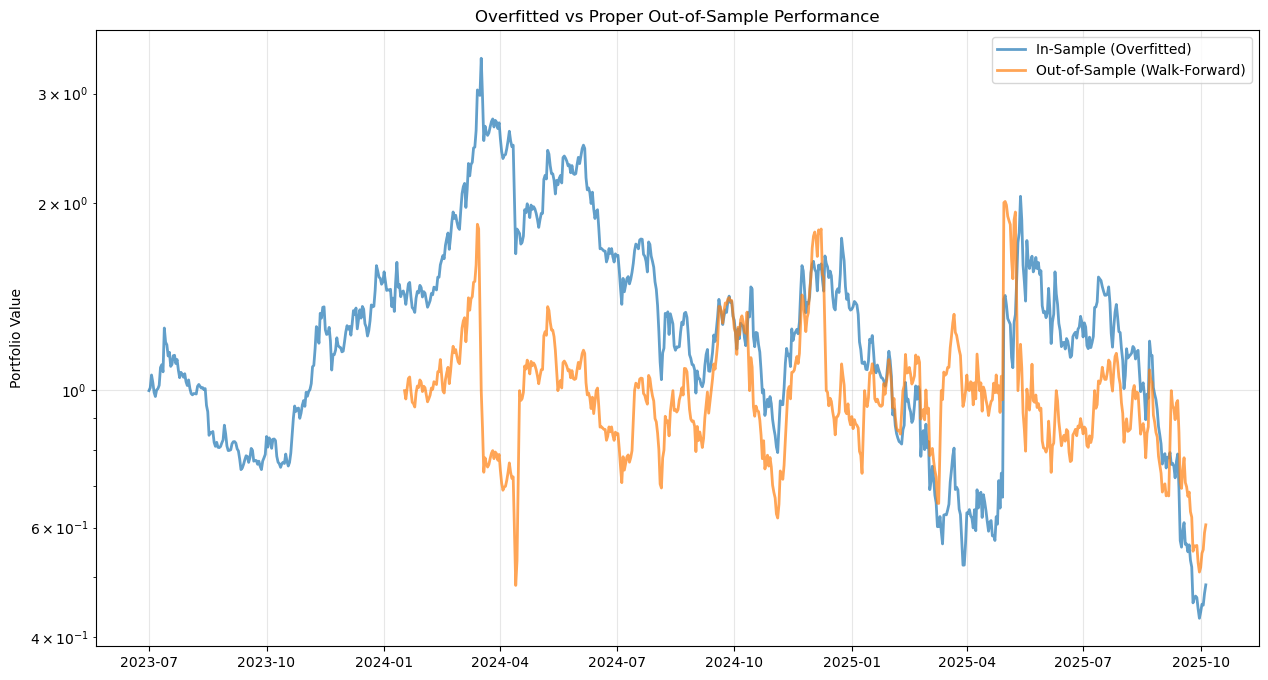


COMPARISON: Overfitted vs Proper Validation

In-Sample (OVERFITTED):
  CAGR: -27.2%
  MDD: -87.5%
  Sharpe: 0.28

Out-of-Sample (Walk-Forward):
  CAGR: -25.8%
  MDD: -74.7%
  Sharpe: 0.62

⚠️  Performance degradation demonstrates overfitting in original Step2!


In [6]:
# Get combined out-of-sample equity curve
oos_equity = wfa.get_combined_equity_curve()

# Compare with in-sample (overfitted) results
from CoinTrading.backtesting import BacktestEngine
from CoinTrading.strategy import MomentumLongOnlyStrategy

# In-sample (entire dataset - OVERFITTED)
strategy_overfitted = MomentumLongOnlyStrategy(indicator='mom7', long_top_n=5, long_bottom=False)
engine = BacktestEngine(processed_data, transaction_fee=0.003)
overfitted_equity = engine.run(strategy_overfitted.get_weights)

# Plot comparison
plt.figure(figsize=(15, 8))
plt.title('Overfitted vs Proper Out-of-Sample Performance')
plt.plot(overfitted_equity.index, overfitted_equity.values, 
         label='In-Sample (Overfitted)', linewidth=2, alpha=0.7)
plt.plot(oos_equity.index, oos_equity.values, 
         label='Out-of-Sample (Walk-Forward)', linewidth=2, alpha=0.7)
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylabel('Portfolio Value')
plt.show()

# Calculate metrics
from CoinTrading.backtesting.metrics import calculate_cagr, calculate_mdd, calculate_sharpe

print("\n" + "="*80)
print("COMPARISON: Overfitted vs Proper Validation")
print("="*80)
print(f"\nIn-Sample (OVERFITTED):")
print(f"  CAGR: {calculate_cagr(overfitted_equity)*100:.1f}%")
print(f"  MDD: {calculate_mdd(overfitted_equity)*100:.1f}%")
print(f"  Sharpe: {calculate_sharpe(overfitted_equity.pct_change().dropna()):.2f}")

print(f"\nOut-of-Sample (Walk-Forward):")
print(f"  CAGR: {calculate_cagr(oos_equity)*100:.1f}%")
print(f"  MDD: {calculate_mdd(oos_equity)*100:.1f}%")
print(f"  Sharpe: {calculate_sharpe(oos_equity.pct_change().dropna()):.2f}")

print(f"\n⚠️  Performance degradation demonstrates overfitting in original Step2!")

## 5. Compare: Overfitted vs Proper Validation

INFO:CoinTrading.strategy.momentum_simple:Initialized MomentumSimple(mom7): long_top=5, short_bottom=5, indicator=mom7, universe=21
INFO:CoinTrading.backtesting.engine:Initialized backtesting engine with 403 symbols, 829 trading days
INFO:CoinTrading.backtesting.engine:Running backtest from 2023-06-30 to 2025-10-05
INFO:CoinTrading.backtesting.engine:Backtest complete. Final equity: 0.0000 (-100.00%)


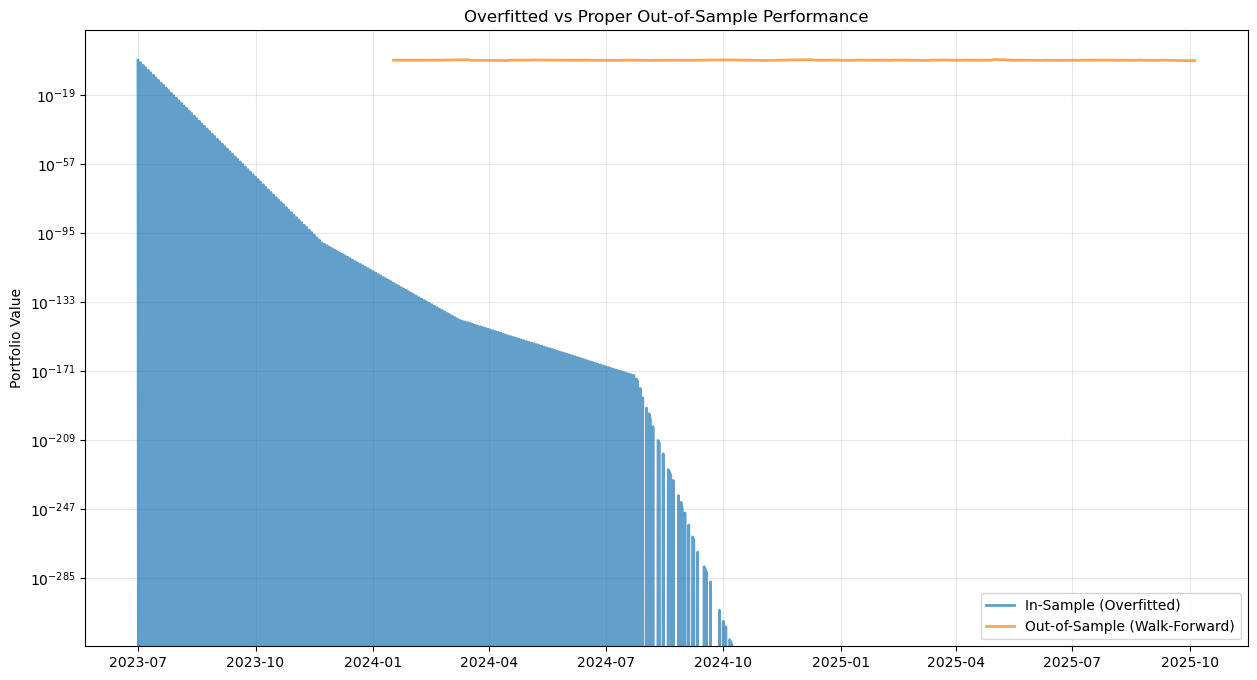


COMPARISON: Overfitted vs Proper Validation

In-Sample (OVERFITTED):
  CAGR: 0.0%
  MDD: -120.2%
  Sharpe: -111.36

Out-of-Sample (Walk-Forward):
  CAGR: -25.8%
  MDD: -74.7%
  Sharpe: 0.62

⚠️  Performance degradation demonstrates overfitting in original Step2!


In [7]:
# Get combined out-of-sample equity curve
oos_equity = wfa.get_combined_equity_curve()

# Compare with in-sample (overfitted) results
from CoinTrading.backtesting import BacktestEngine
from CoinTrading.strategy import MomentumSimpleStrategy

# In-sample (entire dataset - OVERFITTED)
strategy_overfitted = MomentumSimpleStrategy(indicator='mom7')
engine = BacktestEngine(processed_data, transaction_fee=0.003)
overfitted_equity = engine.run(strategy_overfitted.get_weights)

# Plot comparison
plt.figure(figsize=(15, 8))
plt.title('Overfitted vs Proper Out-of-Sample Performance')
plt.plot(overfitted_equity.index, overfitted_equity.values, 
         label='In-Sample (Overfitted)', linewidth=2, alpha=0.7)
plt.plot(oos_equity.index, oos_equity.values, 
         label='Out-of-Sample (Walk-Forward)', linewidth=2, alpha=0.7)
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylabel('Portfolio Value')
plt.show()

# Calculate metrics
from CoinTrading.backtesting.metrics import calculate_cagr, calculate_mdd, calculate_sharpe

print("\n" + "="*80)
print("COMPARISON: Overfitted vs Proper Validation")
print("="*80)
print(f"\nIn-Sample (OVERFITTED):")
print(f"  CAGR: {calculate_cagr(overfitted_equity)*100:.1f}%")
print(f"  MDD: {calculate_mdd(overfitted_equity)*100:.1f}%")
print(f"  Sharpe: {calculate_sharpe(overfitted_equity.pct_change().dropna()):.2f}")

print(f"\nOut-of-Sample (Walk-Forward):")
print(f"  CAGR: {calculate_cagr(oos_equity)*100:.1f}%")
print(f"  MDD: {calculate_mdd(oos_equity)*100:.1f}%")
print(f"  Sharpe: {calculate_sharpe(oos_equity.pct_change().dropna()):.2f}")

print(f"\n⚠️  Performance degradation demonstrates overfitting in original Step2!")

## Summary: The Overfitting Problem

### Original Step2 Issues:
❌ Tested on entire dataset
❌ No train/test split
❌ Selected parameters based on inflated performance
❌ Results were unrealistically optimistic

### Our Solution:
✅ Train/Validation/Test splits (60/20/20)
✅ Optimize on train, select on validation
✅ Report realistic out-of-sample performance
✅ Walk-forward analysis for time-series data
✅ Degradation analysis to detect overfitting

### Key Lesson:
**Never test on the same data you optimized on!**

This is why the new implementation is far more robust for real trading.

Next: [04_market_timing.ipynb](04_market_timing.ipynb)